## FYS-STK4155 
## Project 1

This notebook uses own code for machine learning algorithms etc. 

### Configure Notebook


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os

import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tqdm import tqdm_notebook as tqdm

from mylearn.linear_model import LinearRegression, RidgeRegression
from mylearn.ml_tools import *
from mylearn.project_tools import fig_path

# Set fontsizes in figures
params = {'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rc('text', usetex=True)

import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

### Franke's function

Franke's bivariate test function, commonly just called Franke's function, is a widely used test function in interpolartion and fitting problems. As seen in the plot below, Franke's function has two Gaussian peaks and a Gaussian dip. 

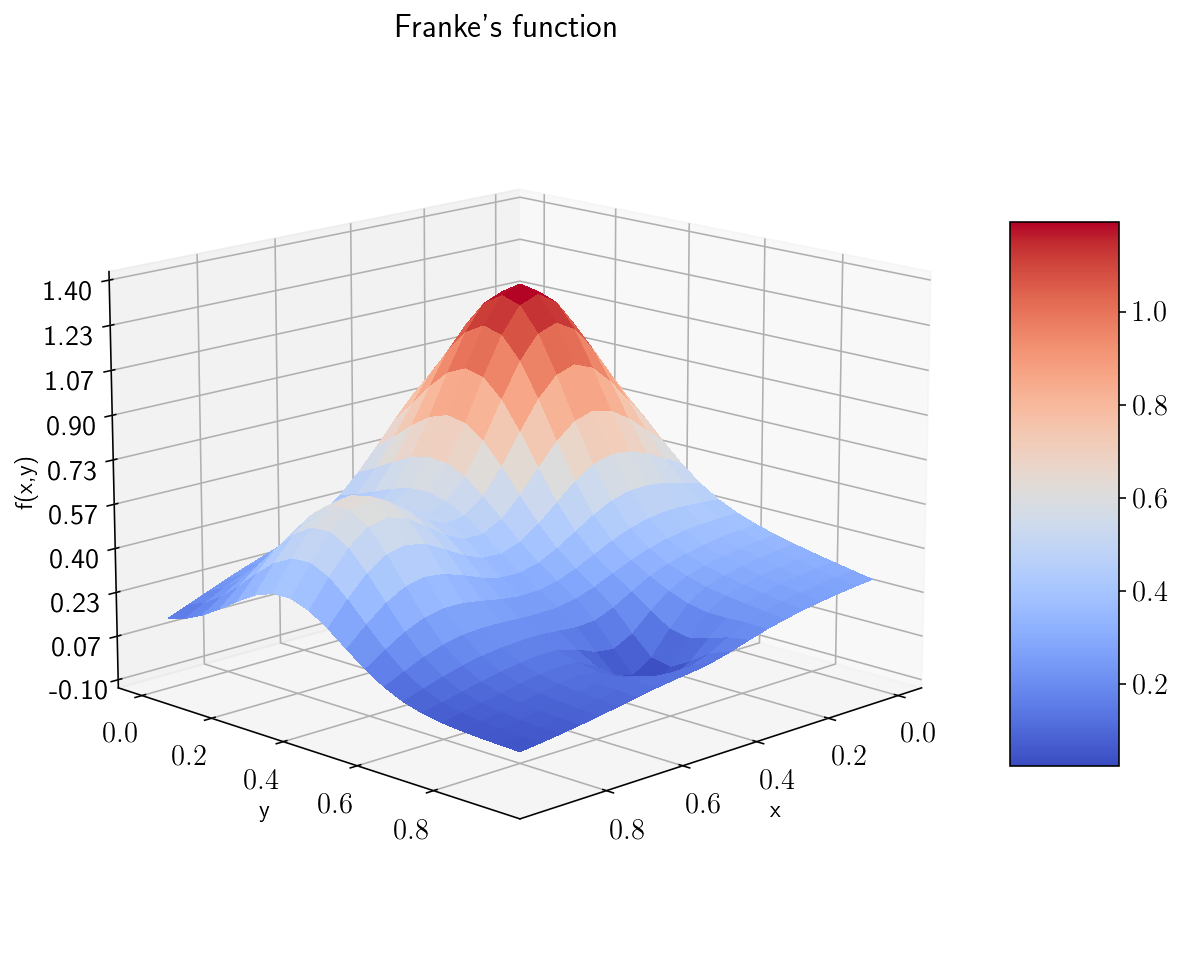

In [2]:
plotFranke(save=True)

# Ordinary Least Squares (OLS) Regression

## Part a)

### Create Data and Perform Ordinary Least Squares (OLS) Linear Regression

Here, we perform an ordinary least squares regression analysis using polynomials in $x$ and $y$ up to the fifth order. We split the data into training and test sets, and also scale the data. 

In [3]:
# Create data
np.random.seed(42)

n = 100          # number of data points
deg = 5          # degree
sigma2 = 0.001   # irreducible error

# x = np.random.uniform(0, 1, n)
# y = np.random.uniform(0, 1, n)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma2, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)
print(f"Design matrix shape: {X.shape}")

# Split data into train and test sets
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scale the data, i.e, subtract the mean and divide by std (based on the training set)
X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)

# Create linear regression object
ols_linreg = LinearRegression(fit_intercept=True)

# Train the model using the (scaled) training sets
ols_linreg.fit(X_train_scaled, z_train)

# Intercept and coefficients
beta0 = ols_linreg.intercept_
beta = ols_linreg.coef_
print(f"Intercept: {beta0}")
print("Coefficients: \n", beta)
print(f"Coefficients shape: {beta.shape}")

# MSE
mse_train = ols_linreg.mse(X_train_scaled, z_train)
mse_test = ols_linreg.mse(X_test_scaled, z_test)
print(f"Train MSE: {mse_train}")
print(f"Test MSE: {mse_test}")

# R2
r2_train = ols_linreg.r2(X_train_scaled, z_train)
r2_test = ols_linreg.r2(X_test_scaled, z_test)
print(f"Train R2: {r2_train}")
print(f"Test R2: {r2_test}")

Design matrix shape: (10000, 20)
Intercept: 0.407011877137768
Coefficients: 
 [  2.28213418   1.08144017 -10.33009742  -3.35102077  -2.47004449
  13.90335248   8.92917029   4.01004306  -2.55419538  -6.47716632
  -9.77236504  -1.29295833  -5.20255291   8.04151688   0.40831116
   3.23114729   1.57568605  -0.80163504   2.7014713   -4.2276273 ]
Coefficients shape: (20,)
Train MSE: 0.002074360835297822
Test MSE: 0.0021265271026953635
Train R2: 0.9749504649040798
Test R2: 0.9735919267437343


### MSE and R2 as a function of model complexity

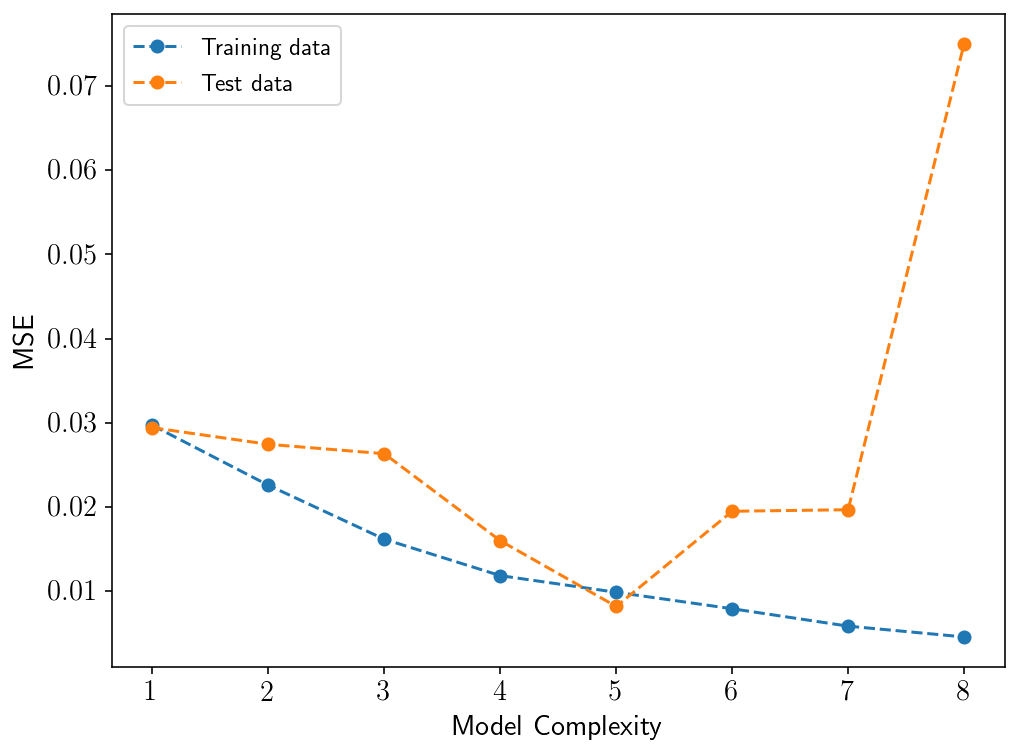

In [4]:
# Create data
np.random.seed(42)

n = 10         # number of data points
sigma2 = 0.1   # irreducible error

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma2, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

maxdeg = 8
degrees = np.arange(1, maxdeg+1, dtype=int)

mse = pd.DataFrame(columns=["train", "test"], index=degrees-1)
r2 = pd.DataFrame(columns=["train", "test"], index=degrees-1)

for i, deg in enumerate(tqdm(degrees)):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)

    # Split data into train and test sets
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
    X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)

    # Create linear regression object
    ols_linreg = LinearRegression(fit_intercept=True)

    # Train the model using the (scaled) training sets
    ols_linreg.fit(X_train_scaled, z_train)
    z_fit = ols_linreg.predict(X_train_scaled)

    # Make predictions using the test set
    z_pred = ols_linreg.predict(X_test_scaled)

    # Statistical metrics
    mse["train"][i] = ols_linreg.mse(X_train_scaled, z_train)
    mse["test"][i] = ols_linreg.mse(X_test_scaled, z_test)    
    r2["train"][i] = ols_linreg.r2(X_train_scaled, z_train)
    r2["test"][i] = ols_linreg.r2(X_test_scaled, z_test)


fig = plt.figure(figsize=(8,6))
plt.plot(degrees, mse["train"], "o--", label="Training data")
plt.plot(degrees, mse["test"], "o--", label="Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()
plt.show()
fig.savefig(fig_path("MSE_forced_overfit.png"), dpi=300)

Figure shows an example of forced overfitting. Small error, increasing complexity good with training data (more flexible, hits the training), but with test data it does not generalize well. 

## Confidence Interval

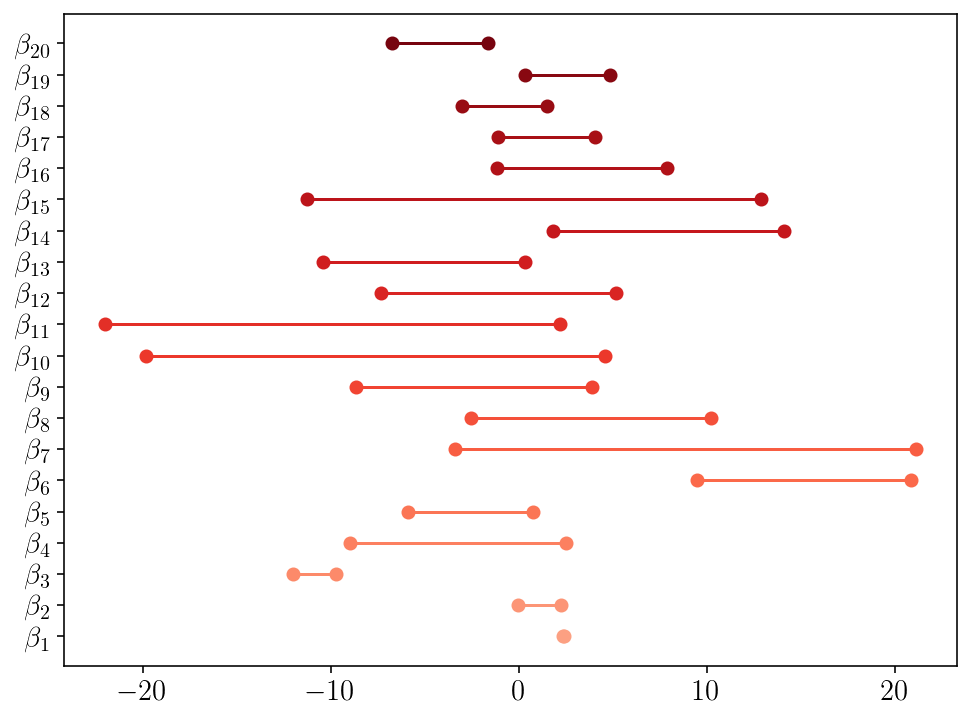

In [5]:
# Create data
np.random.seed(42)

n = 100        # n x n number of data points
sigma2 = 0.1   # irreducible error
deg = 5

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma2, int(n*n))

# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)

# Split data into train and test sets
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scale the data, i.e, subtract the mean and divide by std (based on the training set)
X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)

# Create linear regression object
ols_linreg = LinearRegression(fit_intercept=True)

# Train the model using the (scaled) training sets
ols_linreg.fit(X_train_scaled, z_train)

# CI
Coef_interval = ols_linreg.coef_CI(critical_value=1.96)

# Plot the CI
plot_CI(Coef_interval, save=True)

## Bootstrap

### Part b) 

The bootstrap method is a widely used resampling technique for identically distributed random variables...  

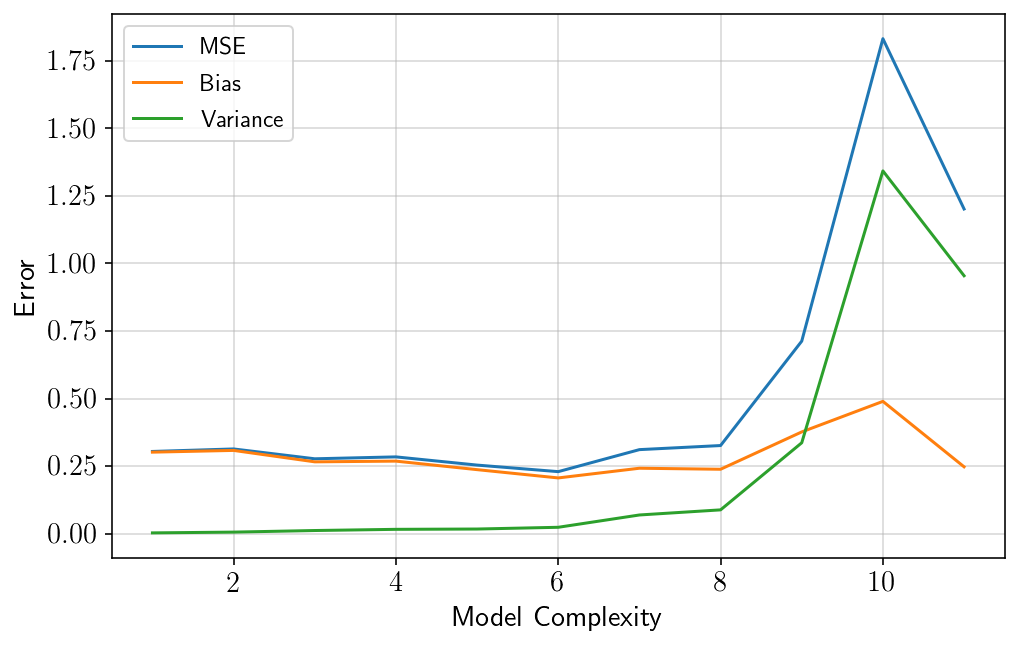

In [6]:
# Create data
np.random.seed(41)

n = 20         # number of data points
sigma2 = 0.5   # irreducible error

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma2, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for bootstrap
maxdeg = 11
degrees = np.arange(1, maxdeg+1, dtype=int)
n_bootstraps = 500

bias2 = np.zeros(maxdeg)
variance = np.zeros(maxdeg)

for i, deg in enumerate(tqdm(degrees)):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)

    # Split data into train and test sets
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
    X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
    
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    
    for trial_idx in range(n_bootstraps):
        X_, z_ = resample(X_train_scaled, z_train)
        ols_linreg = LinearRegression(fit_intercept=True)
        ols_linreg.fit(X_, z_)
        z_pred[:, trial_idx] = ols_linreg.predict(X_test_scaled)
    
    bias2[i] = np.mean((z_test - np.mean(z_pred, axis=1))**2) # bias^2
    variance[i] = np.mean(np.var(z_pred, axis=1))
    
MSE = bias2 + variance
fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.5)
plt.plot(degrees, MSE, label='MSE')
plt.plot(degrees, bias2, label='Bias')
plt.plot(degrees, variance, label='Variance')
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.legend()
plt.show()
fig.savefig(fig_path("bias_variance_ols.png"), dpi=300)

# Ridge Regression

## Part d)

### Bootstrap

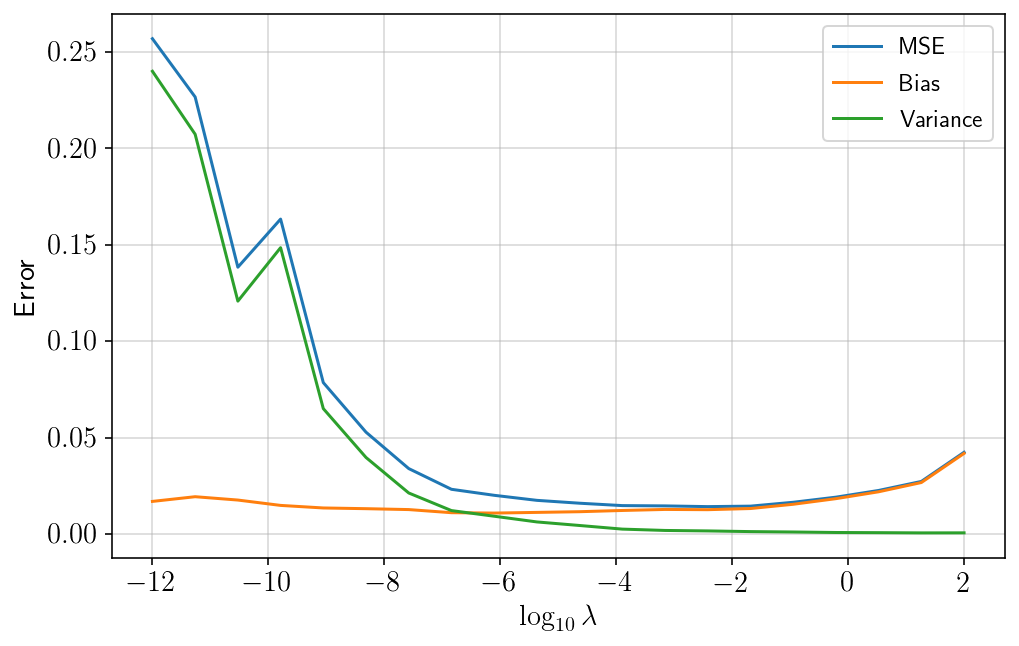

In [7]:
# Create data
np.random.seed(41)

n = 20         # n x n number of data points
sigma2 = 0.1   # irreducible error

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma2, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# Generate design matrix
deg = 12
X = designMatrix(x, y, deg, with_intercept=False)

# Split data into train and test sets
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scale the data
X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)

# Setup for bootstrap
N = 20
lmbdas = np.logspace(-12, 2, N)
n_bootstraps = 500

bias2 = np.zeros(N)
variance = np.zeros(N)

for i, lmbda in enumerate(tqdm(lmbdas)):
    
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    
    for trial_idx in range(n_bootstraps):
        X_, z_ = resample(X_train_scaled, z_train)
        ridge_reg = RidgeRegression(lmbda=lmbda, fit_intercept=True)
        ridge_reg.fit(X_, z_)
        z_pred[:, trial_idx] = ridge_reg.predict(X_test_scaled)
    
    bias2[i] = np.mean((z_test - np.mean(z_pred, axis=1))**2) # bias^2
    variance[i] = np.mean(np.var(z_pred, axis=1))
    
MSE = bias2 + variance
fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.5)
plt.plot(np.log10(lmbdas), MSE, label='MSE')
plt.plot(np.log10(lmbdas), bias2, label='Bias')
plt.plot(np.log10(lmbdas), variance, label='Variance')
plt.xlabel(r"$\log_{10} \lambda$")
plt.ylabel("Error")
plt.legend()
plt.show()
fig.savefig(fig_path("bias_variance_ridge.png"), dpi=300)

# Lasso Regression

## Part e)

### Bootstrap

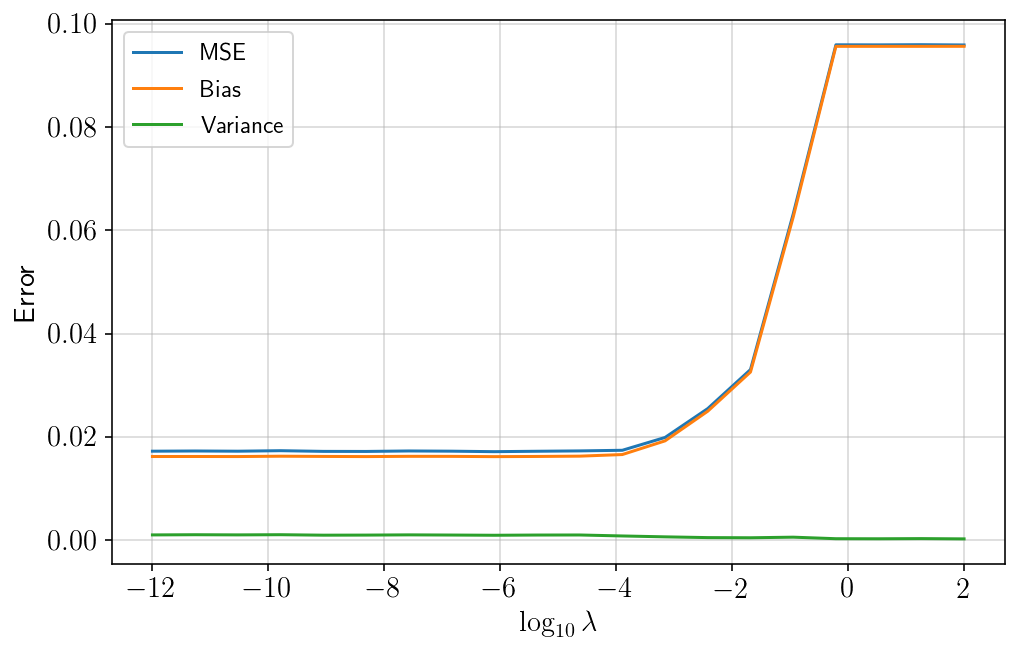

In [8]:
# Create data
np.random.seed(41)

n = 20         # n x n number of data points
sigma2 = 0.1   # irreducible error

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma2, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# Generate design matrix
deg = 12
X = designMatrix(x, y, deg, with_intercept=False)

# Split data into train and test sets
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scale the data
X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)

# Setup for bootstrap
N = 20
lmbdas = np.logspace(-12, 2, N)
n_bootstraps = 500

bias2 = np.zeros(N)
variance = np.zeros(N)

for i, lmbda in enumerate(tqdm(lmbdas)):
    
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    
    for trial_idx in range(n_bootstraps):
        X_, z_ = resample(X_train_scaled, z_train)
        lasso_reg = Lasso(alpha=lmbda, fit_intercept=True)
        lasso_reg.fit(X_, z_)
        z_pred[:, trial_idx] = lasso_reg.predict(X_test_scaled)
    
    bias2[i] = np.mean((z_test - np.mean(z_pred, axis=1))**2) # bias^2
    variance[i] = np.mean(np.var(z_pred, axis=1))
    
MSE = bias2 + variance
fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.5)
plt.plot(np.log10(lmbdas), MSE, label='MSE')
plt.plot(np.log10(lmbdas), bias2, label='Bias')
plt.plot(np.log10(lmbdas), variance, label='Variance')
plt.xlabel(r"$\log_{10} \lambda$")
plt.ylabel("Error")
plt.legend()
plt.savefig("bootstrap_lasso.png")
plt.show()
fig.savefig(fig_path("bias_variance_lasso.png"), dpi=300)